In [1]:
# load package
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation  import train_test_split
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import cross_validation

# set path
import os
default_path = "/Users/francislin/Desktop/Machine_Learning_Workshop/Titanic/"
os.chdir(default_path)

# skip interaction warning
import warnings; 
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Data Prepararion
# read data
train=pd.read_csv('train.csv',encoding='big5')
test=pd.read_csv('test.csv',encoding='big5')
submit=pd.read_csv('gender_submission.csv',encoding='big5')

In [3]:
# append in ONE data
data=train.append(test, ignore_index=True)

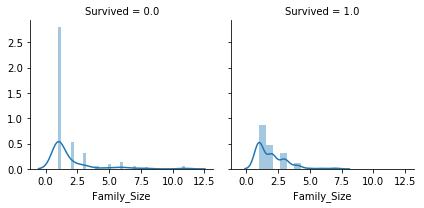

In [4]:
data['Family_Size']=data['Parch']+data['SibSp']+1
g=sns.FacetGrid(data,col='Survived')
g.map(sns.distplot,'Family_Size',kde=True)#kde是否要折線圖的參數

In [5]:
#設法整理出「尊稱」這個因子
data['Title1']=data['Name'].str.split('.',expand=True)[0]
#expand=True是讓資料在dataframe展開欄位
#1是選第二項的title
data['Title1'].head(10)
# 切出尊稱
data['Title1']=data['Title1'].str.split(', ',expand=True)[1].str.strip()#[1]代表切出第2個'dlm'前面到第一個的字串
data['Title1'].head(10)
# 秀出dintinct後的title1
data['Title1'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [6]:
#合併成比較常出現的姓氏在Title2
data['Title2']=''
for idx, row in data.iterrows():  # 請務必記得加上idx，不然跑回圈的item會變成(idx, row)
    Sex = row['Sex']
    Title1=row['Title1']
    if Title1=='Master':
        Title2='Master'
    elif Title1=='Mrs':
        Title2='Mrs'
    elif Title1=='Miss':
        Title2='Miss'
    elif Sex=='male':
        Title2='Mr'
    else:
        Title2='Miss'
    data.loc[idx,'Title2']=Title2 #???
data['Title2'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

In [ ]:
# 票的前幾碼代號可能有意義，流水編沒有所以拿掉
data['Ticket_info'] = data['Ticket'].apply(lambda x : x.replace(".","").replace("/","").strip().split(' ')[0] if not x.isdigit() else 'X')
data['Ticket_info'].unique()

In [7]:
data['Ticket_info'] = data['Ticket'].apply(lambda x : x.upper().replace(".","").strip().split(' ')[0] if not x.isdigit() else 'X')
data['Ticket_info'].unique()

array(['A/5', 'PC', 'STON/O2', 'X', 'PP', 'CA', 'SC/PARIS', 'SC/A4',
       'A/4', 'SP', 'SOC', 'SO/C', 'W/C', 'SOTON/OQ', 'WEP', 'STON/O',
       'A4', 'C', 'SOP', 'A5', 'FA', 'LINE', 'FCC', 'SW/PP', 'SCO/W',
       'P/PP', 'SC', 'SC/AH', 'A/S', 'WE/P', 'SO/PP', 'FC', 'SOTON/O2',
       'CA/SOTON', 'SC/A3', 'STON/OQ', 'AQ/4', 'A', 'LP', 'AQ/3'],
      dtype=object)

In [8]:
tt = data.groupby(by='Ticket_info', as_index=False).agg({'PassengerId': pd.Series.nunique})
tt

,Ticket_info,PassengerId
0,A,1
1,A/4,9
2,A/5,25
3,A/S,1
4,A4,1
5,A5,3
6,AQ/3,1
7,AQ/4,1
8,C,8
9,CA,68


In [ ]:
tt['PassengerId'].describe()

In [ ]:
#把count distinct的ticket_info低於第一四分位數的都改成None
tt['Ticket_info_rev']=tt['Ticket_info']
tt.Ticket_info_rev[tt.PassengerId<14]='None' #STONO是14
tt

In [ ]:
#leftjoin Ticket_info_rev到大表
tt=tt.drop(['PassengerId'], axis=1)
data=pd.merge(left=data, right=tt,how='left', on=['Ticket_info', 'Ticket_info'])
data.head(4)

In [9]:
# 抓船艙第一碼英文
# 送出kaggle成績沒有比較好，一堆空的也是合理
data['Cabin_info']=data['Cabin'].str[:1]
data['Cabin_info']=data['Cabin_info'].fillna('N')#空的補N
data['Cabin_info'].unique()

array(['N', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [ ]:
'''
data['Cabin_info2']=data['Cabin_info']
data.Cabin_info2[data.Cabin_info in ('N','C')]='mm'
data.head()'''

In [10]:
#整併人數太少的cabin
#把'F','G','T'變成'Merged'
data['Cabin_info'].replace(['F','G','T'],'Merged',inplace=True)#inplace如果是false就是改爽的不會更動到值

In [11]:
#
print('Embarked原遺漏的人數：',data['Embarked'].isnull().sum())
#最多在S港上傳，填補遺漏值
data['Embarked']=data['Embarked'].fillna('S')

Embarked原遺漏的人數： 2


In [12]:
#
print('Fare原遺漏的人數：',data['Fare'].isnull().sum())
#用平均填補遺漏值
data['Fare']=data['Fare'].fillna(data['Fare'].mean())

Fare原遺漏的人數： 1


In [ ]:
#
#print('Age遺漏的人數：',data['Age'].isnull().sum())
#用中位數填補遺漏值
#data['Age']=data['Age'].fillna(data['Age'].median())

In [13]:
#用(找是否有別名
data['NickName_ind']= data['Name'].str.contains('\(',na=False)*1
data['Quotation_ind']= data['Name'].str.contains('\"',na=False)*1
qta = data.groupby(by='Quotation_ind', as_index=False).agg({'PassengerId': pd.Series.nunique})
qta.head()

,Quotation_ind,PassengerId
0,0,1234
1,1,75


In [14]:
deplicate_ticket = []
for tk in data.Ticket.unique():
    tem = data.loc[data.Ticket == tk, 'Fare']
    #print(tem.count())
    if tem.count() > 1:
        #print(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare']])
        deplicate_ticket.append(data.loc[data.Ticket == tk,['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Family_Size', 'Title1',
       'Title2', 'Ticket_info', 'Ticket_info_rev', 'Cabin_info',
       'NickName_ind', 'Quotation_ind']])
deplicate_ticket = pd.concat(deplicate_ticket)
df_fri = deplicate_ticket.loc[(deplicate_ticket.Family_Size == 1) & (deplicate_ticket.Survived.notnull())].head(7)
df_fami = deplicate_ticket.loc[(deplicate_ticket.Family_Size > 1) & (deplicate_ticket.Survived.notnull())].head(7)
display(df_fri,df_fami)
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print('friends: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_Size == 1]))
print('families: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_Size > 1]))
# the same ticket family or friends
data['Connected_Survival'] = 0.5 # default 
for _, df_grp in data.groupby('Ticket'):
    if (len(df_grp) > 1):
        for ind, row in df_grp.iterrows():
            smax = df_grp.drop(ind)['Survived'].max()
            smin = df_grp.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data.loc[data['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0):
                data.loc[data['PassengerId'] == passID, 'Connected_Survival'] = 0
#print
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print("people have connected information : %.0f" 
      %(data[data['Connected_Survival']!=0.5].shape[0]))
data.groupby('Connected_Survival')[['Survived']].mean().round(3)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Title1,Title2,Ticket_info,Ticket_info_rev,Cabin_info,NickName_ind,Quotation_ind
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,1,Mr,Mr,X,NaN,E,0,0
20,35.0,NaN,S,26.0000,"Fynney, Mr. Joseph J",0,21,2,male,0,0.0,239865,1,Mr,Mr,X,NaN,N,0,0
791,16.0,NaN,S,26.0000,"Gaskell, Mr. Alfred",0,792,2,male,0,0.0,239865,1,Mr,Mr,X,NaN,N,0,0
195,58.0,B80,C,146.5208,"Lurette, Miss. Elise",0,196,1,female,0,1.0,PC 17569,1,Miss,Miss,PC,NaN,B,0,0
681,27.0,D49,C,76.7292,"Hassab, Mr. Hammad",0,682,1,male,0,1.0,PC 17572,1,Mr,Mr,PC,NaN,D,0,0
61,38.0,B28,S,80.0000,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,1,Miss,Miss,X,NaN,B,0,0
829,62.0,B28,S,80.0000,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,1,Mrs,Mrs,X,NaN,B,1,0


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Title1,Title2,Ticket_info,Ticket_info_rev,Cabin_info,NickName_ind,Quotation_ind
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Mrs,Mrs,PC,NaN,C,1,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,Mrs,Mrs,X,NaN,C,1,0
137,37.0,C123,S,53.1000,"Futrelle, Mr. Jacques Heath",0,138,1,male,1,0.0,113803,2,Mr,Mr,X,NaN,C,0,0
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,5,Master,Master,X,NaN,N,0,0
24,8.0,NaN,S,21.0750,"Palsson, Miss. Torborg Danira",1,25,3,female,3,0.0,349909,5,Miss,Miss,X,NaN,N,0,0
374,3.0,NaN,S,21.0750,"Palsson, Miss. Stina Viola",1,375,3,female,3,0.0,349909,5,Miss,Miss,X,NaN,N,0,0
567,29.0,NaN,S,21.0750,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",4,568,3,female,0,0.0,349909,5,Mrs,Mrs,X,NaN,N,1,0


people keep the same ticket: 596 
friends: 127 
families: 469 
people keep the same ticket: 596 
people have connected information : 496


,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


In [15]:
data.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Family_Size', 'Title1',
       'Title2', 'Ticket_info', 'Cabin_info', 'NickName_ind', 'Quotation_ind',
       'Connected_Survival'],
      dtype='object')

In [22]:
#留下準備get_dummies的欄位
for_dummy_data=data.drop(['Name','Cabin','Ticket','Title1'], axis=1)
for_dummy_data.head(3)

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Family_Size,Title2,Ticket_info,Cabin_info,NickName_ind,Quotation_ind,Connected_Survival
0,22.0,S,7.2500,0,1,3,male,1,0.0,2,Mr,A/5,N,0,0,0.5
1,38.0,C,71.2833,0,2,1,female,1,1.0,2,Mrs,PC,C,1,0,0.5
2,26.0,S,7.9250,0,3,3,female,0,1.0,1,Miss,STON/O2,N,0,0,0.5


In [23]:
data_dummies = pd.get_dummies(for_dummy_data)
#columns可以指定哪些欄位要get_dummies
data_dummies.head(3)
#data= pd.merge(left=data, right=data_dummies, how='left', left_on='PassengerId', right_on='PassengerId',)
#data.head(4)

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,Family_Size,NickName_ind,Quotation_ind,...,Ticket_info_WE/P,Ticket_info_WEP,Ticket_info_X,Cabin_info_A,Cabin_info_B,Cabin_info_C,Cabin_info_D,Cabin_info_E,Cabin_info_Merged,Cabin_info_N
0,22.0,7.2500,0,1,3,1,0.0,2,0,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,0,2,1,1,1.0,2,1,0,...,0,0,0,0,0,1,0,0,0,0
2,26.0,7.9250,0,3,3,0,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [29]:
for_dummy_data.columns

Index(['Age', 'Embarked', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'Sex',
       'SibSp', 'Survived', 'Family_Size', 'Title2', 'Ticket_info',
       'Cabin_info', 'NickName_ind', 'Quotation_ind', 'Connected_Survival'],
      dtype='object')

In [ ]:
#感覺是把文字類別轉成某種數字
#get_dummies了所以不必這一cell
'''
data['Sex'] = data['Sex'].astype('category').cat.codes
data['Embarked'] = data['Embarked'].astype('category').cat.codes
data['Pclass'] = data['Pclass'].astype('category').cat.codes
data['Title2'] = data['Title2'].astype('category').cat.codes
data['Ticket_info'] = data['Ticket_info'].astype('category').cat.codes
data['Cabin_info'] = data['Cabin_info'].astype('category').cat.codes
data.head(4)
'''

In [31]:
# 運用'Survived'欄位來判斷訓練集還是測試集
dataTrain = for_dummy_data[pd.notnull(for_dummy_data['Survived'])].sort_values(by=["PassengerId"])
dataTest = for_dummy_data[~pd.notnull(for_dummy_data['Survived'])].sort_values(by=["PassengerId"])
dataTrain = dataTrain[['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Survived', 'Family_Size', 'Title2', 'Ticket_info',
       'Cabin_info', 'NickName_ind', 'Quotation_ind', 'Connected_Survival']]
dataTest = dataTest[['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Family_Size', 'Title2', 'Ticket_info',
       'Cabin_info', 'NickName_ind', 'Quotation_ind', 'Connected_Survival']]

In [ ]:
# 運用'Survived'欄位來判斷訓練集還是測試集
dataTrain = data_dummies[pd.notnull(data_dummies['Survived'])].sort_values(by=["PassengerId"])
dataTest = data_dummies[~pd.notnull(data_dummies['Survived'])].sort_values(by=["PassengerId"])
dataTrain.columns
dataTrain = dataTrain[['Age', 'Fare', 'Parch', 'Pclass','Survived', 'SibSp','Quotation_ind', 'Connected_Survival',
       'Family_Size', 'NickName_ind', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female',
       'Sex_male', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs',# 'Title2_Master',
       #'Ticket_info_rev_A4', 'Ticket_info_rev_A5', 'Ticket_info_rev_CA',
       #'Ticket_info_rev_FCC', 'Ticket_info_rev_None', 'Ticket_info_rev_PC',
       #'Ticket_info_rev_SCPARIS', 'Ticket_info_rev_SOTONOQ', 'Ticket_info_rev_WC','Ticket_info_rev_STONO'
       'Ticket_info_rev_X',
       #'Cabin_info_A', 'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_Merged'
       'Cabin_info_E', 'Cabin_info_N']]
dataTest = dataTest[['Age', 'Fare', 'Parch', 'Pclass', 'SibSp','Quotation_ind', 'Connected_Survival',
       'Family_Size', 'NickName_ind', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female',
       'Sex_male', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs',# 'Title2_Master',
       #'Ticket_info_rev_A4', 'Ticket_info_rev_A5', 'Ticket_info_rev_CA',
       #'Ticket_info_rev_FCC', 'Ticket_info_rev_None', 'Ticket_info_rev_PC',
       #'Ticket_info_rev_SCPARIS', 'Ticket_info_rev_SOTONOQ', 'Ticket_info_rev_WC','Ticket_info_rev_STONO',
       'Ticket_info_rev_X',
       #'Cabin_info_A', 'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_Merged'
       'Cabin_info_E', 'Cabin_info_N']]

In [32]:
# Function for Measure Performance
from  sklearn  import  metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True):
    y_pred = clf.predict(X)
    y_predprob = clf.predict_proba(X)[:,1]
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred))),"\n"

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y,y_pred)),"\n"
        
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y,y_pred)),"\n"  
        
    if show_roc_auc:
        print("ROC AUC Score")
        print(metrics.roc_auc_score(y,y_predprob)),"\n"

In [33]:
# use LabelEncoder to convert categorical features to int type before construct Dataset
from sklearn.preprocessing import LabelEncoder
def label_encoder(input_df, encoder_dict=None):
    """ Process a dataframe into a form useable by LightGBM """
    # Label encode categoricals
    categorical_feats = input_df.columns[input_df.dtypes == 'object']
    for feat in categorical_feats:
        encoder = LabelEncoder()
        input_df[feat] = encoder.fit_transform(input_df[feat].fillna('NULL'))
    return input_df, categorical_feats.tolist(), encoder_dict
dataTrain, categorical_feats, encoder_dict = label_encoder(dataTrain)
X = dataTrain.drop('Survived', axis=1)
y = dataTrain.Survived

# Prepare dataset 
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=seed)

In [61]:
# Grid Search
print('Start training...')
estimator = lgb.LGBMClassifier(objective = 'binary', n_estimators = 100, random_state=0)

param_grid = {
    'learning_rate': [0.04],#[0.03,0.05,0.07] then 0.03 [0.02,0.03,0.04] then 0.04 [0.03,0.04,0.05] then 0.04
    'num_leaves': [10,20,30],
    #[30,40,50] then 30 [20,25,30] then 20 [17,20,23] then 17 [15,17,19] then 15 [14,15,16] then 14
    #[13,14,15] then 13 [11,12,13] then 11 [7,8,9,10,11] then 7 [5,6,7] then 5
    'feature_fraction': [0.1,0.3,0.5,0.7],#[0.4,0.6,0.8] then 0.4 [0.3,0.4,0.5] then 0.4
    'bagging_fraction': [0.1,0.4,0.7],#[0.6,0.7,0.8], then 0.6 [0.4,0.5,0.6] then 0.4 [0.3,0.4,0.5] then 0.3
    #[0.2,0.3,0.4] then 0.2 [0.1,0.2,0.3] then 0.1 [0.05,0.1,0.2] then 0.05 [0.025,0.05,0.1] then 0.025
    #[0.0125,0.025,0.05] then 0.0125 [0.01,0.02,0.03] then 0.01
    'max_depth':[5],#[4,6,8] then 6 [5,6] then 5 [4,5] then 4
    'max_bin':[15], #[10,15,20] then 15 [13,15,17] then 15 [14,15,16] then 15
    'lambda_l1':[0.7],#[0.1,0.2,0.3] then 0.3 [0.3,0.4,0.5] then 0.5 [0.5,0.6,0.7] then 0.7
    'lambda_l2':[0.03], #[0.08,0.09,0.1] then 0.08 [0.06,0.07,0.08] then 0.06 [0.04,0.05,0.06] then 0.05
    'min_split_gain':[0.03,0.04,0.05],#[0.05,0.06,0.07]then 0.07 [0.05,0.06,0.07] then 0.06 [0.03,0.04,0.05] then 0.03
    'min_child_weight':[3,4] #[3,5,7] then 5 [4,5,6] then 5 [4,5,6] then 4 [3,4,5] then 4
}

LGBM_grid = GridSearchCV(estimator, param_grid)
LGBM_grid.fit(X_train, y_train)
print('Best parameters found by grid search are:', LGBM_grid.best_params_)

# Final Model
evals_result = {} 
print('Start predicting...')
LGBM_grid_final = lgb.LGBMClassifier(objective = 'binary',
                                      #learning_rate = 0.05, 
                                     learning_rate = LGBM_grid.best_params_['learning_rate'],
                                     n_estimators = 100, 
                                     random_state=0,
                              num_leaves = LGBM_grid.best_params_['num_leaves'],
                                feature_fraction = LGBM_grid.best_params_['feature_fraction'], 
                              bagging_fraction = LGBM_grid.best_params_['bagging_fraction'],
                             max_depth = LGBM_grid.best_params_['max_depth'],
                              max_bin = LGBM_grid.best_params_['max_bin'],
                              lambda_l1 = LGBM_grid.best_params_['lambda_l1'],
                              lambda_l2 = LGBM_grid.best_params_['lambda_l2'],
                            min_split_gain = LGBM_grid.best_params_['min_split_gain'],
                            min_child_weight = LGBM_grid.best_params_['min_child_weight'])
LGBM_grid_final_fit = LGBM_grid_final.fit(X_train, y_train)
print('Predicting is over')

Start training...
Best parameters found by grid search are: {'bagging_fraction': 0.1, 'feature_fraction': 0.5, 'lambda_l1': 0.7, 'lambda_l2': 0.03, 'learning_rate': 0.04, 'max_bin': 15, 'max_depth': 5, 'min_child_weight': 4, 'min_split_gain': 0.03, 'num_leaves': 20}
Start predicting...
Predicting is over


Accuracy:0.810
Classification report
             precision    recall  f1-score   support

        0.0       0.79      0.92      0.85       156
        1.0       0.86      0.65      0.74       112

avg / total       0.82      0.81      0.80       268

Confusion matrix
[[144  12]
 [ 39  73]]
ROC AUC Score
0.8705070970695972
Feature importances: [185, 44, 150, 9, 75, 46, 26, 43, 58, 50, 69, 25, 7, 98]
Plot feature importances...


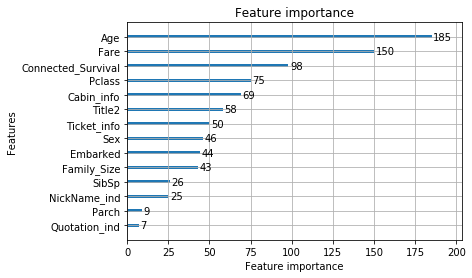

In [62]:
#對test算
LGBM_grid_measure = measure_performance(X = X_test, y = y_test, clf = LGBM_grid_final, show_classification_report=True, show_confusion_matrix=True)

# feature importances
print('Feature importances:', list(LGBM_grid_final.feature_importances_))

# visualization
print('Plot feature importances...')
ax = lgb.plot_importance(LGBM_grid_final_fit, max_num_features=25)
plt.show()

In [63]:
dataTrain, categorical_feats, encoder_dict = label_encoder(dataTest)

In [64]:
#predict Test data
#submit the data to kaggle
LGBM_grid_final_fit_res =LGBM_grid_final_fit.predict(dataTest)
submit['Survived'] = LGBM_grid_final_fit_res
#submit['Survived'] = GBDT_res
submit['Survived'] = submit['Survived'].astype(int)

In [65]:
submit.to_csv('submit_to_kaggle.csv', index= False)
%pwd

'/Users/francislin/Desktop/Machine_Learning_Workshop/Titanic'

In [ ]:
print("一樣的x去做")
#print('\n')
print("CART:"+"Your submission scored 0.74641")
print("RF:"+"Your submission scored 0.76076")
print("GBDT:"+"Your submission scored 0.77511")
print("RF(18個X):"+"Your submission scored 0.79425")
print("lightGBM(用綽號、年紀遺漏不處理):"+"Your submission scored 0.79904")
print("lightGBM(用綽號、年紀遺漏不處理、加Connected_Survival Quotation_ind):"+"Your submission scored 0.80861")
print("lightGBM(同上，調參數):"+"Your submission scored 0.81339")

#### Important Features Using Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

In [28]:
clf.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
imp = sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), X_train.columns), reverse=True)
rf_imp = pd.DataFrame(imp, columns=['importances', 'features'])
rf_imp